### Input

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Функции

In [2]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [3]:
def show_corr_bars(df, features, target):
    corr_with_target = df[features + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with target variable')
    plt.show()

In [4]:
def create_subject_col(df):
    _df = df.copy()
    _df.loc[_df[PHYSICS] == 1, SUBJECT] = 1
    _df.loc[_df[CHEMISTRY] == 1, SUBJECT] = 2
    _df.loc[_df[BIOLOGY] == 1, SUBJECT] = 3
    _df.loc[_df[ENGLISH] == 1, SUBJECT] = 4
    _df.loc[_df[GEOGRAPHY] == 1, SUBJECT] = 5
    _df.loc[_df[HISTORY] == 1, SUBJECT] = 6
    _df.loc[_df[SUBJECT].isnull(), SUBJECT] = 0
    return _df

In [5]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Загрузка данных

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [7]:
ID = "Id"
AGE = "age"
YEAR_OF_EXPERIENCE = "years_of_experience"
LESSON_PRICE = "lesson_price"
QUALIFICATION = "qualification"
PHYSICS = "physics"
CHEMISTRY = "chemistry"
BIOLOGY = "biology"
GEOGRAPHY = "geography"
HISTORY = "history"
MEAN_EXAM_POINTS = "mean_exam_points"
ENGLISH = "english"
TARGET = "choose"
SUBJECT = "subject"

In [8]:
BASE_FEATURE_NAMES = df.columns.drop([TARGET, ID]).tolist()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


### Анадиз данных

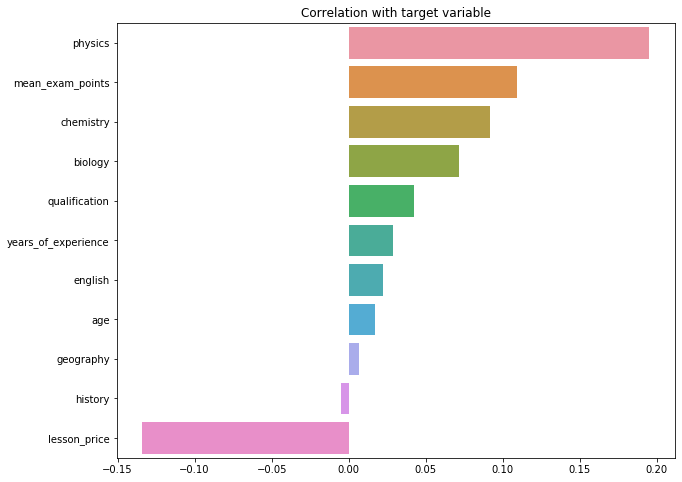

In [10]:
show_corr_bars(df, BASE_FEATURE_NAMES, TARGET)

### Отбор признаков

In [11]:
# Создаем новый признак и собираем в него все предметы
df = create_subject_col(df)
df_test = create_subject_col(df_test)
BASE_FEATURE_NAMES = [AGE, YEAR_OF_EXPERIENCE, LESSON_PRICE, QUALIFICATION, SUBJECT, MEAN_EXAM_POINTS]

In [12]:
# Признаки которые будут использованы
BASE_FEATURE_NAMES

['age',
 'years_of_experience',
 'lesson_price',
 'qualification',
 'subject',
 'mean_exam_points']

In [13]:
# scaling ??

### Балансировка таргетного класса

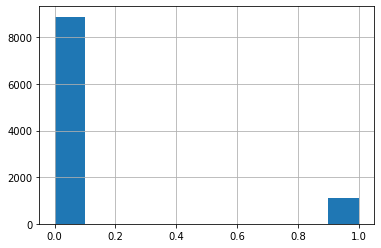

In [14]:
df[TARGET].hist()

In [15]:
df_balanced = balance_df_by_target(df, TARGET)

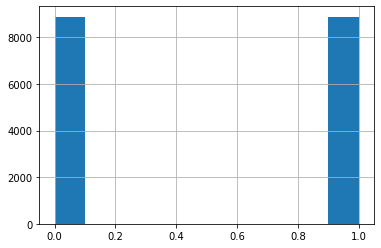

In [16]:
df_balanced[TARGET].hist()

In [17]:
df = df_balanced

### Desicion tree, построение модели

In [18]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [19]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction  

In [20]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [21]:
# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [22]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [23]:
# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [24]:
# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [25]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [26]:
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Обучение модели и проверка качества

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[BASE_FEATURE_NAMES], df[TARGET], test_size=0.25)

In [28]:
%%time

custom_tree = build_tree_classification(X_train.to_numpy(), y_train.to_numpy(), max_depth=100)

Wall time: 7.48 s


In [29]:
y_train_pred = predict_class(X_train.to_numpy(), custom_tree)
y_test_pred = predict_class(X_test.to_numpy(), custom_tree)
                            
print(f'Точность на трейне - {accuracy_metric(y_train_pred, y_train.to_numpy())}')
print(f'Точность на тесте - {accuracy_metric(y_test_pred, y_test.to_numpy())}')

Точность на трейне - 92.23089626182255
Точность на тесте - 86.51204683629813


### Финальное обучение на всем датасете, предсказание для теста

In [30]:
%%time

custom_tree = build_tree_classification(df[BASE_FEATURE_NAMES].to_numpy(), df[TARGET].to_numpy(), max_depth=100)

Wall time: 10.3 s


In [31]:
Y = predict_class(df_test[BASE_FEATURE_NAMES].to_numpy(), custom_tree)
df_test["choose"] = Y
df_test.loc[:, ['Id', 'choose']].to_csv('Kolchedantsev_predictions.csv', index=False)

!kaggle competitions submit -c choose-tutors -f Kolchedantsev_predictions.csv -m ""

Successfully submitted to Choose tutors



  0%|          | 0.00/87.9k [00:00<?, ?B/s]
100%|##########| 87.9k/87.9k [00:05<00:00, 17.5kB/s]
